### Loading the csv files

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mon = pd.read_csv('../data/monday.csv', sep=';', parse_dates=[0])
tue = pd.read_csv('../data/tuesday.csv', sep=';', parse_dates=[0])
wed = pd.read_csv('../data/wednesday.csv', sep=';', parse_dates=[0])
thu = pd.read_csv('../data/thursday.csv', sep=';', parse_dates=[0])
fri = pd.read_csv('../data/friday.csv', sep=';', parse_dates=[0])


In [3]:
def fe_matrix(day):
    '''add the checkout to the customers who miss it and
    assign unique identifiers for customers over the week'''
    #find the missing checkouts
    chkt = pd.DataFrame(data=day.groupby('customer_no')['location'].sum().str.slice(start=-3) != 'out')
    lst = list(chkt[chkt['location']==True].index)
    
    #append the new rows for missing checkouts
    mnt = day['timestamp'].max()+datetime.timedelta(minutes=1)
    count = 0
    for i in range(len(lst)):
        day.loc[len(day)+count] = [mnt,lst[i],'checkout']
        count = count+1
        
        
    #update the customer columns adding the weekly day
    lst2 = ['m_','tu_','w_','th_','fr_']
    wd = day.timestamp[1].weekday()
    day['cust_id'] = lst2[wd]+day['customer_no'].astype('str')
   
    return day

In [4]:
# Creating a dataframe that covers the whole week
mon = fe_matrix(mon)
tue = fe_matrix(tue)
wed = fe_matrix(wed)
thu = fe_matrix(thu)
fri = fe_matrix(fri)
df = pd.concat([mon,tue,wed,thu,fri],ignore_index=True) 
df.set_index('timestamp', inplace=True)

### Expanding table's column


In [6]:
#adding the Time column
df.sort_index(inplace=True)
df['time'] = df.index.time 
df

,customer_no,location,cust_id,time
timestamp,,,,
2019-09-02 07:03:00,1,dairy,m_1,07:03:00
2019-09-02 07:03:00,2,dairy,m_2,07:03:00
2019-09-02 07:04:00,3,dairy,m_3,07:04:00
2019-09-02 07:04:00,4,dairy,m_4,07:04:00
2019-09-02 07:04:00,5,spices,m_5,07:04:00
...,...,...,...,...
2019-09-06 21:51:00,1503,checkout,fr_1503,21:51:00
2019-09-06 21:51:00,1505,checkout,fr_1505,21:51:00
2019-09-06 21:51:00,1506,checkout,fr_1506,21:51:00


### Determining the order of states

In [7]:
# finding the min of time in order to indicate the visited first aile of each customer into the supermarket
first_section = df.reset_index().groupby('cust_id')['timestamp'].min()

In [8]:
# Adding a column 'section_order' for adding 'first' visited aile, 
for customer in df["cust_id"].unique():
    df.loc[
        (df['cust_id'] == customer) & (df.index == first_section[customer]),
        "section_order"
    ] = "first"
#'following' for all other visited ailes 
df.loc[df["location"] == "checkout", "section_order"] = "checkout"
# checkout by customers
df['section_order'].fillna('following', inplace=True)
df

,customer_no,location,cust_id,time,section_order
timestamp,,,,,
2019-09-02 07:03:00,1,dairy,m_1,07:03:00,first
2019-09-02 07:03:00,2,dairy,m_2,07:03:00,first
2019-09-02 07:04:00,3,dairy,m_3,07:04:00,first
2019-09-02 07:04:00,4,dairy,m_4,07:04:00,first
2019-09-02 07:04:00,5,spices,m_5,07:04:00,first
...,...,...,...,...,...
2019-09-06 21:51:00,1503,checkout,fr_1503,21:51:00,checkout
2019-09-06 21:51:00,1505,checkout,fr_1505,21:51:00,checkout
2019-09-06 21:51:00,1506,checkout,fr_1506,21:51:00,checkout


### Calculating the probabilities for the first section

In [9]:
# Finding the first aile hat customers visited via section_order as 'first'
customers_in_first_sections = (
    df[df.section_order == 'first'].groupby('location')[['cust_id']].count()
)
customers_in_first_sections

,cust_id
location,
dairy,2141
drinks,1143
fruit,2810
spices,1351


In [10]:
# calculating probabilities 
total_entries = sum(customers_in_first_sections['cust_id'].to_list())
first_probabilities = customers_in_first_sections / total_entries
first_probabilities

,cust_id
location,
dairy,0.287576
drinks,0.153526
fruit,0.377435
spices,0.181464


### 1. The total number of customers in each location

In [11]:
location_sum = df.groupby('location')[['cust_id']].count().sort_values('cust_id')
location_sum

,cust_id
location,
spices,3754
drinks,3905
dairy,4679
fruit,5122
checkout,7445


In [12]:
# daily average of customer per location
location_avg = round(location_sum / 5, 0).astype(int)
location_avg

,cust_id
location,
spices,751
drinks,781
dairy,936
fruit,1024
checkout,1489


### 2. Number of customer per location over time

In [13]:
# Weekly number of customer per location per min
df.groupby(['time', 'location'])[['cust_id']].count()

cust_id
time     location         
07:00:00 dairy           3
         drinks          3
         fruit           4
07:01:00 checkout        2
         dairy           4
...                    ...
21:50:00 dairy           3
         drinks          1
         fruit           2
         spices          1
21:51:00 checkout       20

[4384 rows x 1 columns]

In [14]:
# Average (daily) customer per min per location
avg_customers_location = df.groupby(['time', 'location'])[['cust_id']].count()/5
avg_customers_location

cust_id
time     location         
07:00:00 dairy         0.6
         drinks        0.6
         fruit         0.8
07:01:00 checkout      0.4
         dairy         0.8
...                    ...
21:50:00 dairy         0.6
         drinks        0.2
         fruit         0.4
         spices        0.2
21:51:00 checkout      4.0

[4384 rows x 1 columns]

In [15]:
# total number of customers per day per min per location
customers_location = df.groupby([df.index, 'location'])[['cust_id']].count()
customers_location

cust_id
timestamp           location         
2019-09-02 07:03:00 dairy           2
2019-09-02 07:04:00 dairy           2
                    fruit           1
                    spices          3
2019-09-02 07:05:00 checkout        2
...                               ...
2019-09-06 21:50:00 dairy           1
                    drinks          1
                    fruit           1
                    spices          1
2019-09-06 21:51:00 checkout        8

[13844 rows x 1 columns]

### 3. Number of customers at checkout over time

In [16]:
# Weekly number of customers at checkout over the time
checkout = df[df['location'] == 'checkout']
checkout.groupby(['timestamp', 'location'])[['cust_id']].count()

,,cust_id
timestamp,location,
2019-09-02 07:05:00,checkout,2
2019-09-02 07:06:00,checkout,2
2019-09-02 07:07:00,checkout,1
2019-09-02 07:08:00,checkout,3
2019-09-02 07:09:00,checkout,1
...,...,...
2019-09-06 21:45:00,checkout,1
2019-09-06 21:47:00,checkout,2
2019-09-06 21:48:00,checkout,2


In [17]:
# daily (average) number of customers at checkout over the time
checkout.groupby(['time', 'location'])[['cust_id']].count()/5

,,cust_id
time,location,
07:01:00,checkout,0.4
07:02:00,checkout,1.0
07:03:00,checkout,0.2
07:04:00,checkout,0.4
07:05:00,checkout,1.4
...,...,...
21:47:00,checkout,1.0
21:48:00,checkout,1.4
21:49:00,checkout,1.2


### 4. Time spent in the supermarket

In [18]:
# making a df with customer_id and time at first location
first_location = df.reset_index()[['timestamp', 'cust_id']].groupby('cust_id').min()
first_location.rename(columns={'timestamp': 'entrance_time'}, inplace=True)
first_location.sort_values('entrance_time')

,entrance_time
cust_id,
m_1,2019-09-02 07:03:00
m_2,2019-09-02 07:03:00
m_4,2019-09-02 07:04:00
m_3,2019-09-02 07:04:00
m_5,2019-09-02 07:04:00
...,...
fr_1506,2019-09-06 21:48:00
fr_1507,2019-09-06 21:48:00
fr_1508,2019-09-06 21:48:00


In [19]:
# making a df with customer_id and time at checkout
checkout = df.reset_index()[['timestamp', 'cust_id']].groupby('cust_id').max()
checkout.rename(columns={'timestamp': 'exit_time'}, inplace=True)
checkout.sort_values('exit_time')

,exit_time
cust_id,
m_1,2019-09-02 07:05:00
m_5,2019-09-02 07:05:00
m_3,2019-09-02 07:06:00
m_2,2019-09-02 07:06:00
m_8,2019-09-02 07:07:00
...,...
fr_1503,2019-09-06 21:51:00
fr_1494,2019-09-06 21:51:00
fr_1505,2019-09-06 21:51:00


In [20]:
# merge first_location and checkout dataframe and then subtract exit_time from entrance_time to calculate the total time spent
time_in_market = pd.concat([first_location, checkout], axis=1)
time_in_market['total_time'] = (time_in_market['exit_time'] - time_in_market['entrance_time'])
time_in_market.sort_values('entrance_time')

,entrance_time,exit_time,total_time
cust_id,,,
m_1,2019-09-02 07:03:00,2019-09-02 07:05:00,0 days 00:02:00
m_2,2019-09-02 07:03:00,2019-09-02 07:06:00,0 days 00:03:00
m_4,2019-09-02 07:04:00,2019-09-02 07:08:00,0 days 00:04:00
m_3,2019-09-02 07:04:00,2019-09-02 07:06:00,0 days 00:02:00
m_5,2019-09-02 07:04:00,2019-09-02 07:05:00,0 days 00:01:00
...,...,...,...
fr_1506,2019-09-06 21:48:00,2019-09-06 21:51:00,0 days 00:03:00
fr_1507,2019-09-06 21:48:00,2019-09-06 21:50:00,0 days 00:02:00
fr_1508,2019-09-06 21:48:00,2019-09-06 21:50:00,0 days 00:02:00


### 5. Total number of customers present in the supermarket over time

#### Tracking the location of each customer per minute
* As there was a gap in minutes for customers who spent more than a minute in an aile, the resampling was done to have data for customers' location in every minute  

In [21]:
df_final = df.groupby(['cust_id']).resample('min').ffill()
df_final
# As it can be seen the number of obserbations increased from 7,445 to 53,960

customer_no  location cust_id      time  \
cust_id timestamp                                                      
fr_1    2019-09-06 07:00:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:01:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:02:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:03:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:04:00            1    spices    fr_1  07:04:00   
...                                  ...       ...     ...       ...   
w_998   2019-09-04 16:57:00          998     fruit   w_998  16:57:00   
        2019-09-04 16:58:00          998     fruit   w_998  16:57:00   
        2019-09-04 16:59:00          998  checkout   w_998  16:59:00   
w_999   2019-09-04 16:53:00          999     fruit   w_999  16:53:00   
        2019-09-04 16:54:00          999  checkout   w_999  16:54:00   

                            section_order  
cust_id timestamp                          
fr_1    2019-09-06 07:00:00         first  
        2019-09-06 07:01:00         first  
        2019-09-06 07:02:00         first  
        2019-09-06 07:03:00         first  
        2019-09-06 07:04:00     following  
...                                   ...  
w_998   2019-09-04 16:57:00     following  
        2019-09-04 16:58:00     following  
        2019-09-04 16:59:00      checkout  
w_999   2019-09-04 16:53:00         first  
        2019-09-04 16:54:00      checkout  

[53960 rows x 5 columns]

Checking the old and new data to see if it works 
It works perfectly -> I would add billions of happy emojies but I don't know how

In [22]:
df[df['cust_id'] == 'fr_1']

,customer_no,location,cust_id,time,section_order
timestamp,,,,,
2019-09-06 07:00:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:04:00,1,spices,fr_1,07:04:00,following
2019-09-06 07:05:00,1,checkout,fr_1,07:05:00,checkout


In [23]:
df_final[df_final['cust_id'] == 'fr_1']

customer_no  location cust_id      time  \
cust_id timestamp                                                      
fr_1    2019-09-06 07:00:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:01:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:02:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:03:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:04:00            1    spices    fr_1  07:04:00   
        2019-09-06 07:05:00            1  checkout    fr_1  07:05:00   

                            section_order  
cust_id timestamp                          
fr_1    2019-09-06 07:00:00         first  
        2019-09-06 07:01:00         first  
        2019-09-06 07:02:00         first  
        2019-09-06 07:03:00         first  
        2019-09-06 07:04:00     following  
        2019-09-06 07:05:00      checkout

* In a new data frame 3 rows are added for each minute that the customer remained in dairy aile 

In [24]:
df_final.reset_index(inplace=True, level=0, drop=True)
df_final

,customer_no,location,cust_id,time,section_order
timestamp,,,,,
2019-09-06 07:00:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:01:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:02:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:03:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:04:00,1,spices,fr_1,07:04:00,following
...,...,...,...,...,...
2019-09-04 16:57:00,998,fruit,w_998,16:57:00,following
2019-09-04 16:58:00,998,fruit,w_998,16:57:00,following
2019-09-04 16:59:00,998,checkout,w_998,16:59:00,checkout


### 6. Plotting the distribution of customers of their first visited location Vs. following locations

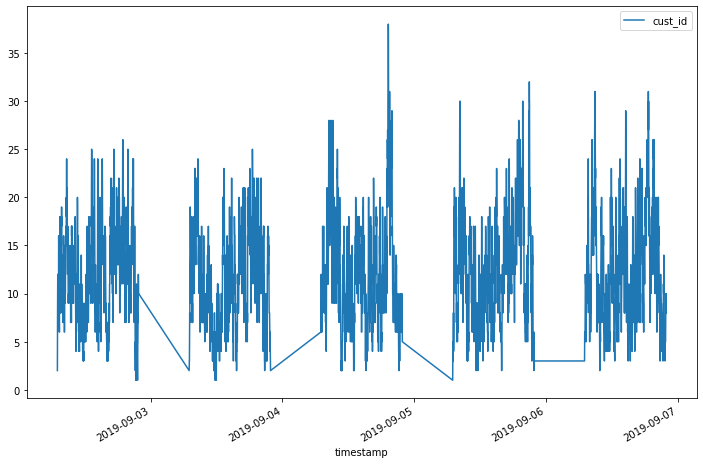

In [25]:
# The whole Week
df_final.groupby(df_final.index)[['cust_id']].count().plot(figsize=(12,8));

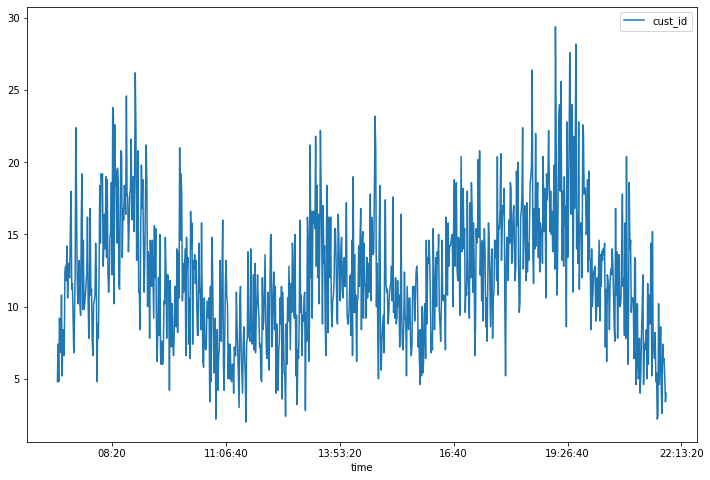

In [26]:
# Average daily  
(df_final.groupby(df_final['time'])[["cust_id"]].count() / 5).plot(figsize=(12, 8));

In [27]:
# Average (daily) number of customers at first location per minute
first = (
    df_final[df_final["section_order"] == "first"]
    .groupby(["time"])[["cust_id"]]
    .count()
    / 5
)
# Average (daily) number of customers at following locations per minute
following = (
    df_final[df_final["section_order"] == "following"]
    .groupby(["time"])[["cust_id"]]
    .count()
    / 5
)


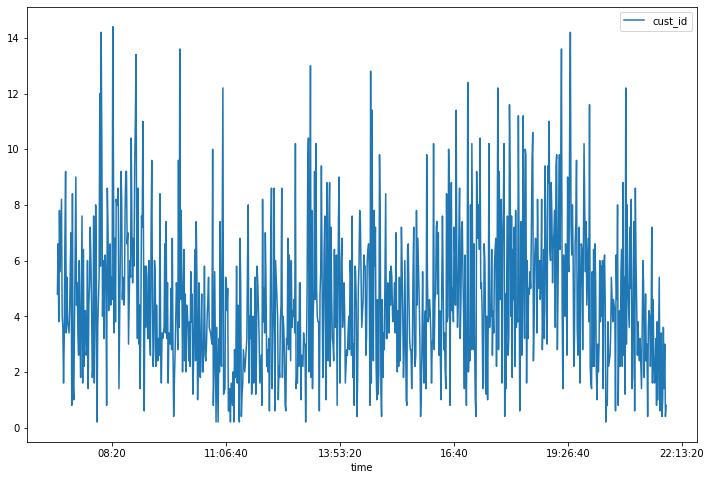

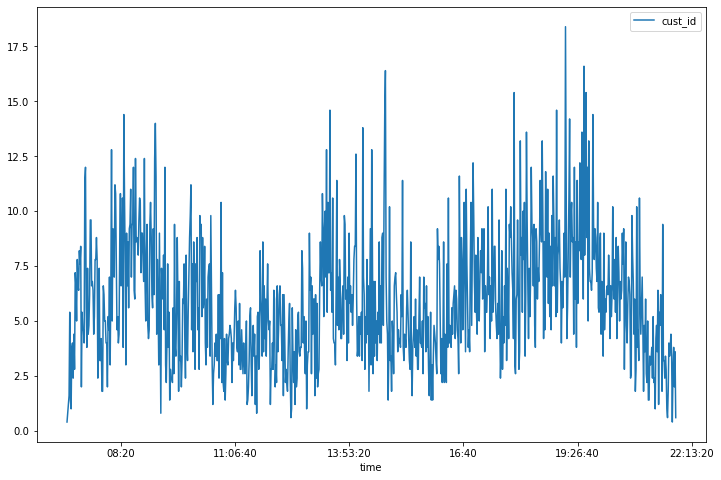

In [32]:
first.plot(figsize=(12,8))
following.plot(figsize=(12,8));

### Adding Revenue to the table

In [33]:
# Hypothetical revenue per minute per location given by the course material
revenues = pd.DataFrame(
    {"location": ["fruit", "spices", "dairy", "drinks"], "revenue": [4, 3, 5, 6]}
)
revenues

,location,revenue
0,fruit,4
1,spices,3
2,dairy,5
3,drinks,6


In [34]:
# filling the empty rows of revenue column per location 
df_final.loc[df_final["location"] == "fruit", "revenue"] = "4"
df_final.loc[df_final["location"] == "spices", "revenue"] = "3"
df_final.loc[df_final["location"] == "dairy", "revenue"] = "5"
df_final.loc[df_final["location"] == "drinks", "revenue"] = "6"
df_final.loc[df_final["location"] == "checkout", "revenue"] = "0"

In [35]:
df_final["revenue"] = df_final["revenue"].astype(int)

In [36]:
df_final

,customer_no,location,cust_id,time,section_order,revenue
timestamp,,,,,,
2019-09-06 07:00:00,1,dairy,fr_1,07:00:00,first,5
2019-09-06 07:01:00,1,dairy,fr_1,07:00:00,first,5
2019-09-06 07:02:00,1,dairy,fr_1,07:00:00,first,5
2019-09-06 07:03:00,1,dairy,fr_1,07:00:00,first,5
2019-09-06 07:04:00,1,spices,fr_1,07:04:00,following,3
...,...,...,...,...,...,...
2019-09-04 16:57:00,998,fruit,w_998,16:57:00,following,4
2019-09-04 16:58:00,998,fruit,w_998,16:57:00,following,4
2019-09-04 16:59:00,998,checkout,w_998,16:59:00,checkout,0


### Saving the final version of dataframe into the CSV file 
* Transition Matrix is calulated in 'transition.py' file

In [37]:
df_final = df_final.sort_values(["timestamp", "cust_id"])
df_final.to_csv('clean_final.csv')